# Membrane Filtration : Direct solve

Let us consider the membrane filtration process where the goal is to maximize the water net production 

```math
    \max_{x(\cdot), u(\cdot)} \int_{0}^{T} u(t) g\big( m(t) \big) \mathrm dt, 
```

where the control $u(\cdot) \in \mathrm L^\infty([0,T], \mathbb R)$ corresponds to the filtration mode (1 during filtration and -1 during backwash) and the state $m (\cdot) \in \mathrm{AC}([0, T], \mathbb R)$ is the mass of the cake layer formed during the water filtration. The dynamic of this state is given by 

```math
    \dot m(t) = \frac{1 + u(t)}{2} f_1(m(t)) - \frac{1 - u(t)}{2} f_2(m(t))
```
with the initial condition $m(0) = m_0$. 

Based on [[Kalboussi et al., 2018](https://doi.org/10.1016/j.ifacol.2017.08.1554)], we assume that $f_1$ and $g$ are smooth $\mathcal L$-function, and that $f_2$ is a smooth $\mathcal K$ function. 

First, we need to import the [Filtration.jl](https://remydutto.github.io/Filtration.jl) to define this Optimal Control Problem, to give it to [OptimalControl.jl](https://control-toolbox.org/OptimalControl.jl) package and [NLPModelsIpopt.jl](jso.dev/NLPModelsIpopt.jl) to solve it. 
We also need to import the [Plots.jl](https://docs.juliaplots.org) package to plot the solution.

In [1]:
using Pkg
Pkg.activate("..")
using Filtration
using CTBase
using OptimalControl
using Plots
using MadNLP
using OrdinaryDiffEq
using MINPACK
using ForwardDiff

  Activating project at `c:\Users\Remy_Dutto\Documents\GitHub\Filtration.jl\docs`


## Model definition 

In this example, these functions are defined by using the [[Benyahia et al.](https://www.researchgate.net/publication/272506325_A_simple_model_of_anaerobic_membrane_bioreactor_for_control_design_coupling_the_AM2b_model_with_a_simple_membrane_fouling_dynamics)] model : 

```math
f_1(m) = \frac{b}{e+m}, \quad f_2(m) = am, \quad f_3(m) = \frac{1}{e+m}, 
```
where $a$, $b$ and $e$ are positive numbers. The problem is simply defined, thanks to `MembraneFiltrationModel`.


In [2]:
# Benyahia & al. model
a = 1; b = 1; e = 1;
f₁ = m ->  b ./ (e .+ m)
f₂ = m -> a .* m
g  = m -> 1 ./ (e .+ m)
model = MembraneFiltrationModel(f₁, f₂, g);


## Verification of hypotheses

With this model, we know that the function $\psi$ defined by 

```math
\psi(m) = g(m)\big[f_{-}'(m) f_{+}(m) - f_{-}(m) f_{+}'(m)\big] + g'(m) f_+(m) f_-(m)
```

have an unique positive root, denoted $\bar m$, where function $f_+$ and $f_-$ are given by 

```math
f_+(m) = \frac{f_1(m) + f_2(m)}{2} \quad \text{and} \quad f_-(m) = \frac{f_1(m) -f_2(m)}{2} \cdot
```

For more information about why this property is needed, please refer to [[Kalboussi et al., 2018](https://doi.org/10.1016/j.ifacol.2017.08.1554)]. However, we can take a look on this function $\psi$. 

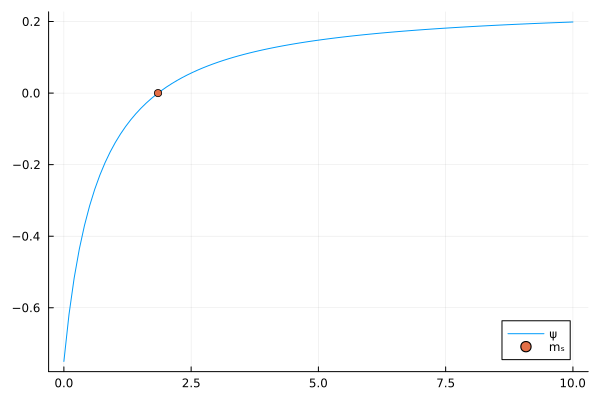

In [9]:
ψ = get_psi(model)
mₛ = singular_state(model)
plot(range(0,10, 100), ψ, label = "ψ")
scatter!([mₛ], [ψ(mₛ)], label = "mₛ")

## Direct Solve

We can solve the optimal control problem by derect method, thanks to the [OptimalControl.jl](https://control-toolbox.org/OptimalControl.jl) package.

The options set during resolve may not have an effect
This is MadNLP version v0.8.5, running with umfpack

Number of nonzeros in constraint Jacobian............:     2502
Number of nonzeros in Lagrangian Hessian.............:      502

Total number of variables............................:      753
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      251
                     variables with only upper bounds:        0
Total number of equality constraints.................:      502
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -1.0000000e-01 9.00e-01 3.42e-02  -1.0 0.00e+00    -  0.00e+00 0.00e+00   0
   1 -5.0890598e-01 7.30e

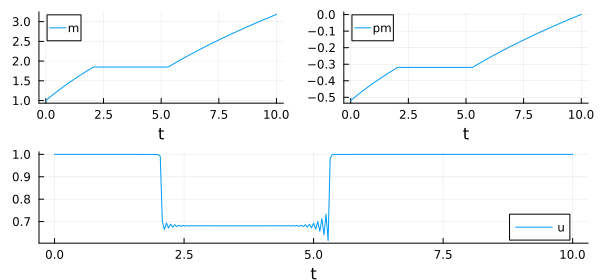

In [11]:
t0 = 0; m0 = 1; tf = 10;                # initial and final time and state
@def ocp begin                          # problem definition
    t ∈ [ t0, tf ], time
    m ∈ R, state
    u ∈ R, control
    -1 ≤ u(t) ≤ 1
    m(t0) == m0
    ṁ(t) == model.state_dynamic(m(t),u(t))
    ∫( model.cost_dynamic(m(t),u(t))) → max
end
sol = OptimalControl.solve(ocp, :madnlp)
plot(sol)

## Indirect solve 

Iter     f(x) inf-norm    Step 2-norm      Step time
------   --------------   --------------   --------------
     1     1.345208e+00     0.000000e+00         0.111000
     2     1.909374e+00     1.028932e+02         0.000000
     3     1.016247e-01     8.690005e+01         0.000000
     4     1.756550e-01     7.528967e-01         0.000000
     5     5.515813e-02     5.751038e-01         0.000000
     6     2.521044e-02     5.280007e+00         0.011000
     7     3.945420e-03     3.736843e-02         0.003000
     8     1.175275e-03     9.041684e-03         0.001000
     9     2.969526e-04     1.085804e-03         0.001000
    10     8.638170e-05     6.065960e-06         0.002000
    11     5.003297e-06     1.101445e-06         0.000000
    12     2.158056e-07     2.607968e-09         0.001000
    13     5.622791e-09     6.194176e-12         0.001000
    14     2.189005e-10     2.922685e-15         0.001000
    15     1.222721e-11     6.891348e-18         0.001000


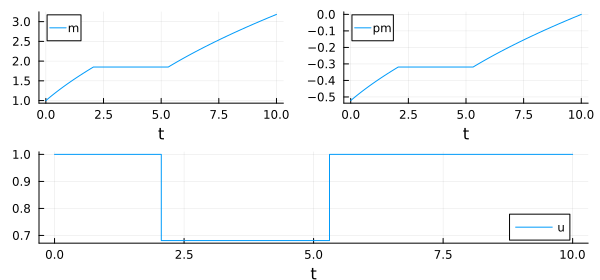

In [12]:
uₛ = singular_control(model)
ϕ₋ = Flow(ocp, (x,p) -> -1)
ϕ₊ = Flow(ocp, (x,p) -> 1)
ϕₛ = Flow(ocp, (x,p) -> singular_control(model))

function S(p)
    λ0 =  p[1]; t1 = p[2]; t2 = p[3]
    Φ = get_phi(model)
    dΦ  = get_dphi(model)

    m1, λ1 = ϕ₊(t0, m0, λ0, t1)
    m2, λ2 = ϕₛ(t1, m1, λ1, t1)
    mf, λf = ϕ₊(t2, m2, λ2, tf)

    return [Φ(m1, λ1), dΦ(m1, λ1), λf]
    
end

S! = (s, ξ) -> s[:] .= S(ξ)
JS(ξ) = ForwardDiff.jacobian(p -> S(p), ξ)
JS! = (js, ξ) -> js .= JS(ξ)
ξ = [0., 1., 2.]

sol = fsolve(S!, ξ, show_trace = true)
λ0, t1, t2 = sol.x
ϕ = ϕ₊ * (t1, ϕₛ) * (t2, ϕ₊)
sol = ϕ((t0, tf), m0, λ0)
plot(sol)


In [13]:
Δt = delta_t_end(model)    

UndefVarError: UndefVarError: `Flow` not defined in `Filtration`
Suggestion: check for spelling errors or missing imports.
Hint: a global variable of this name may be made accessible by importing CTFlows in the current active module Main
Hint: a global variable of this name also exists in OptimalControl.